In [93]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics


In [95]:
adata_1=sc.read_h5ad("D:\ppppaper\data\seqFISH\seqFish_adata.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 14891 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped'
    var: 'gene_names'
    obsm: 'spatial'

In [96]:
adata_1.obs['celltype_mapped_refined']

embryo2_Pos29_cell10_z2     Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell10_z5     Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z2    Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z5    Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell101_z2                     Low quality
                                        ...             
embryo2_Pos50_cell97_z5                      Spinal cord
embryo2_Pos50_cell98_z2                      Spinal cord
embryo2_Pos50_cell98_z5                      Spinal cord
embryo2_Pos50_cell99_z2                      Spinal cord
embryo2_Pos50_cell99_z5                      Spinal cord
Name: celltype_mapped_refined, Length: 14891, dtype: category
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']

In [101]:
# 筛选 'celltype_mapped_refined' 中的 A、B 和 C 细胞类型
selected_celltypes = ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', 'Cranial mesoderm', 'Definitive endoderm', 'Dermomyotome', 'Endothelium', 'Erythroid', 'ExE endoderm', 'Forebrain/Midbrain/Hindbrain',
                      'Haematoendothelial progenitors', 'Intermediate mesoderm', 'Lateral plate mesoderm', 'Mixed mesenchymal mesoderm', 'NMP', 'Neural crest', 'Presomitic mesoderm', 'Sclerotome', 'Splanchnic mesoderm', 'Surface ectoderm']
filtered_adata = adata_1[adata_1.obs['celltype_mapped_refined'].isin(selected_celltypes), :]

# 查看筛选后的数据维度
print(filtered_adata)

# 保存筛选后的数据
filtered_adata.write('./filtered_seqFish.h5ad')


View of AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped'
    var: 'gene_names'
    obsm: 'spatial'


In [102]:
adata_2=sc.read_h5ad("D:\ppppaper\data\Stereo_seq\E9.5_E1S1.MOSTA.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [104]:
adata_2.obs['annotation']

cell_name
147_104        Cavity
147_105        Cavity
147_106        Cavity
147_107        Cavity
147_108    Mesenchyme
              ...    
253_110        Cavity
253_111        Cavity
253_112        Cavity
253_113        Cavity
253_114        Cavity
Name: annotation, Length: 5913, dtype: category
Categories (12, object): ['AGM', 'Brain', 'Branchial arch', 'Cavity', ..., 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']

In [106]:
selected_celltypes = ['AGM', 'Brain', 'Branchial arch', 'Connective tissue', 'Dermomyotome', 'Heart', 'Liver', 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']
filtered_adata = adata_2[adata_2.obs['annotation'].isin(selected_celltypes), :]

# 查看筛选后的数据维度
print(filtered_adata)

# 保存筛选后的数据
filtered_adata.write('./filtered_Stereoseq.h5ad')


View of AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clo

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

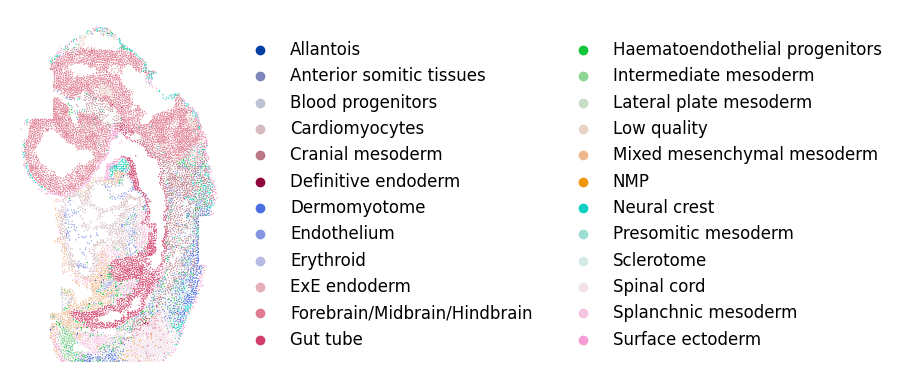

In [12]:
spot_size = 0.8
sc.pl.spatial(adata_1, img_key=None, color=['celltype_mapped_refined'], title=[''],
              legend_fontsize=12, show=False, frameon=False, spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

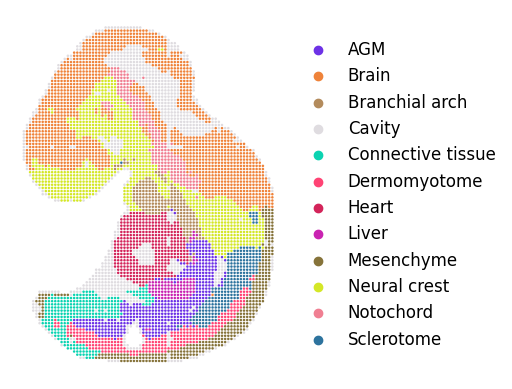

In [13]:
spot_size = 0.8
sc.pl.spatial(adata_2, img_key=None, color=['annotation'], title=[''],
              legend_fontsize=12, show=False, frameon=False, spot_size=spot_size)

In [29]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [81]:
Cal_Spatial_Net(adata_1, k_cutoff=50, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=25, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 816601 edges, 14891 cells.
54.838560204150156 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 151907 edges, 5913 cells.
25.690343311347878 neighbors per cell on average.


In [82]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy

In [83]:
adata_1.obsm['X_dpca'] = features[0].numpy()
adata_2.obsm['X_dpca'] = features[1].numpy()

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


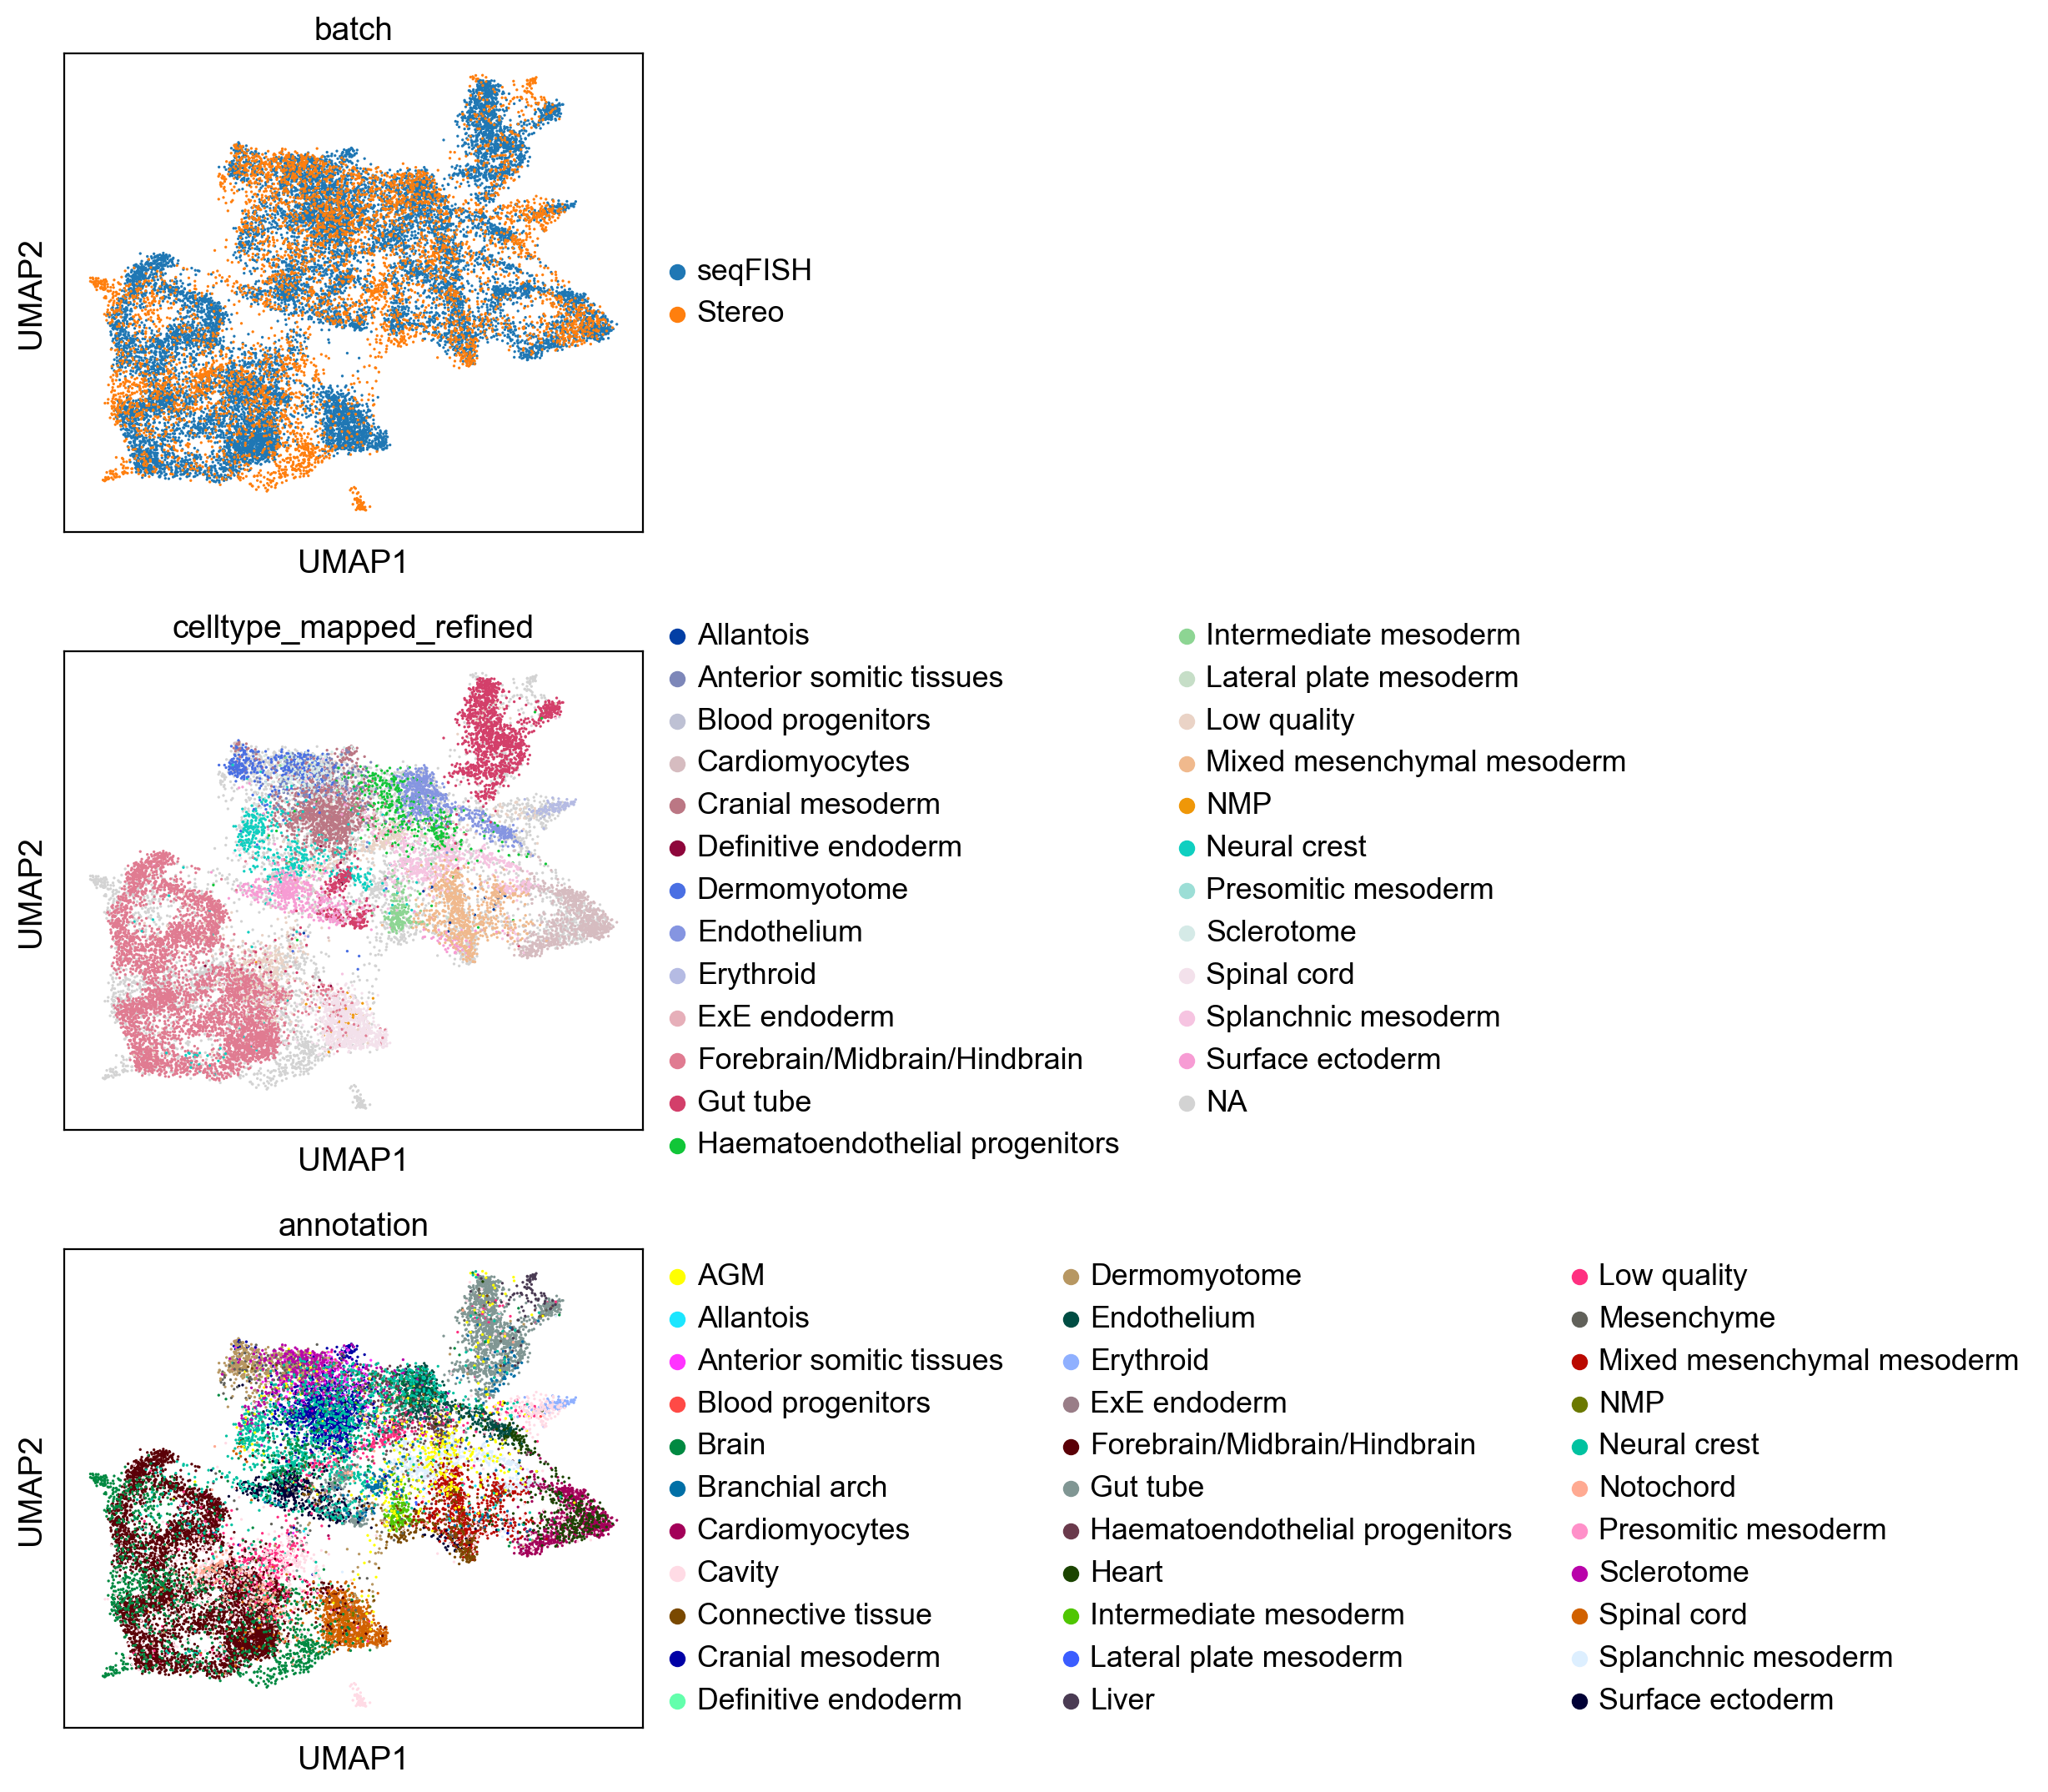

In [84]:
adata = adata_1.concatenate(adata_2, batch_key='batch', batch_categories=['seqFISH', 'Stereo'])
sc.pp.neighbors(adata, use_rep='X_dpca', n_neighbors=20, knn=True)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'celltype_mapped_refined', 'annotation'], ncols = 1)

In [85]:
embd0, embd1, time = run_SLAT_mlp_AGF(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.08 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.08 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.08 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 1 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.08 s ----

---- Ran row_normalize in 0.03 s ----

---------- ep

In [86]:
adata_1.obs['annotation'] = adata_1.obs['celltype_mapped_refined']
adata_1.obsm['scSLAT_bks'] = embd0.detach().cpu().numpy()
adata_2.obsm['scSLAT_bks'] = embd1.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com)


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


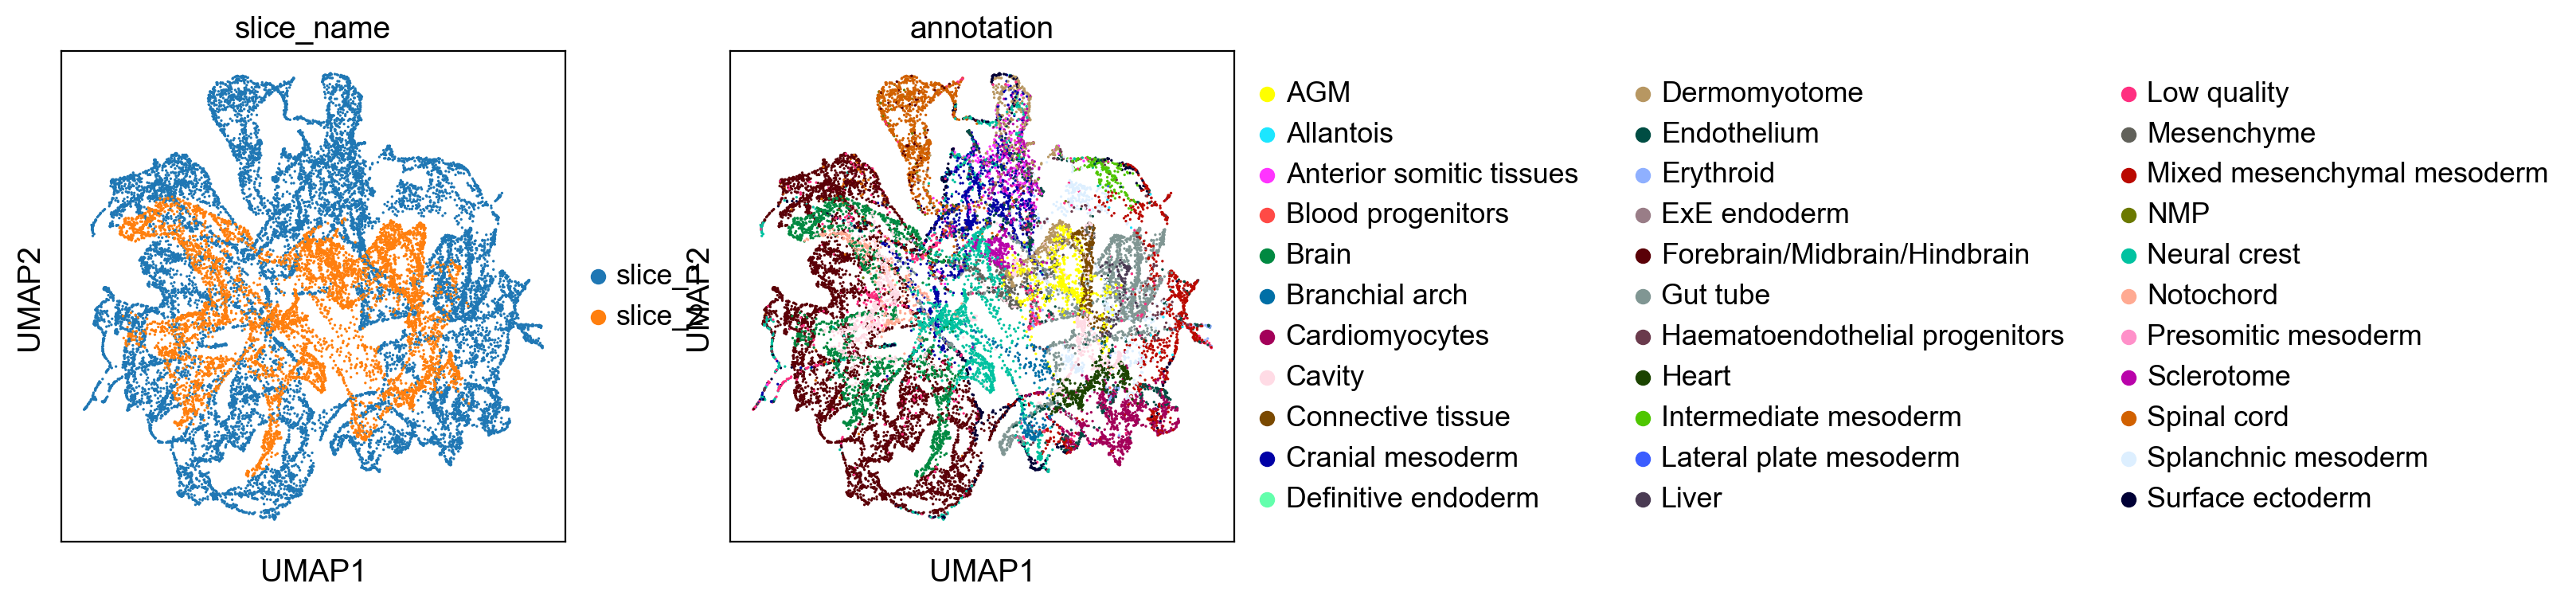

In [87]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [38]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 105.28


In [39]:
adata_1.obsm['scSLAT'] = embd2.detach().cpu().numpy()
adata_2.obsm['scSLAT'] = embd3.detach().cpu().numpy()

adata_com_2 = sc.concat([adata_1,adata_2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


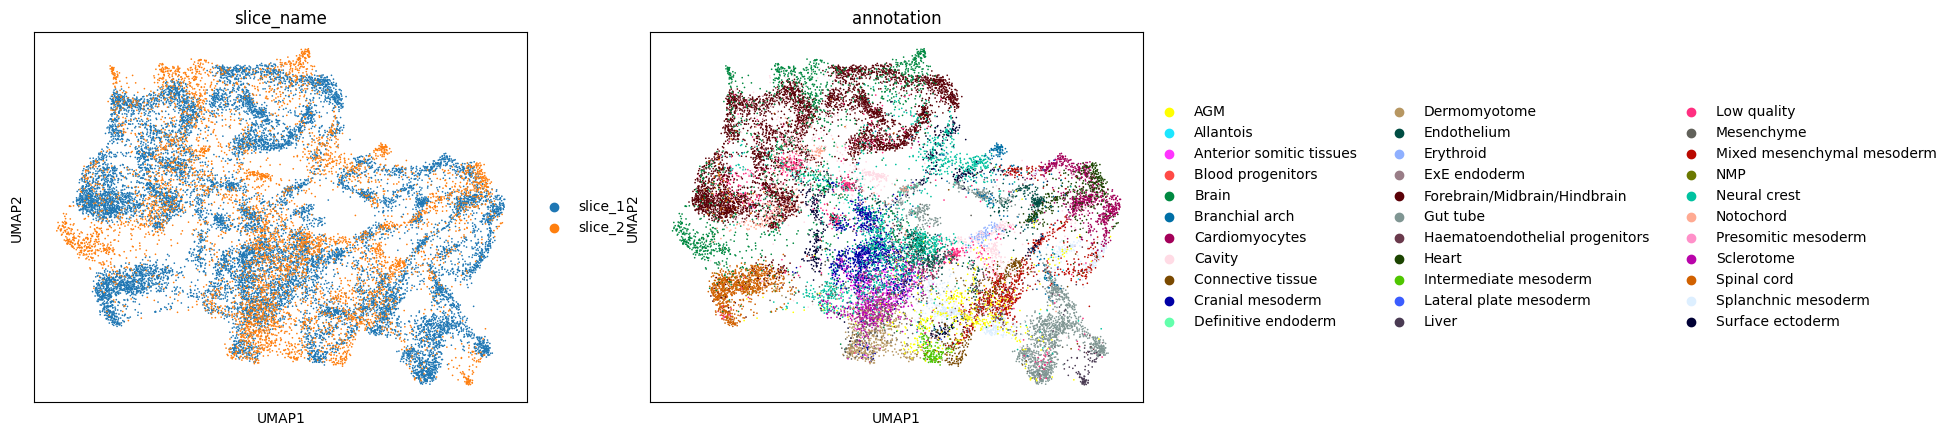

In [40]:
sc.pl.umap(adata_com_2, color= ['slice_name', 'annotation'])

In [88]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [69]:
best_2, index_2, distance_2 = spatial_match([embd2, embd3], adatas=[adata_1, adata_2], reorder=False)
adata3_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata4_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_2 = np.array([range(index.shape[0]), best_2])
best_match_2 = distance_2[:,0]

In [89]:
matching

array([[    0,     1,     2, ...,  5910,  5911,  5912],
       [12445, 12745, 12745, ...,   443,     2,   447]], dtype=int64)

In [71]:
matching_2

array([[    0,     1,     2, ...,  5910,  5911,  5912],
       [12763, 14068, 12815, ...,   914,   235,  1729]], dtype=int64)

In [90]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [73]:
adata4_df['target_celltype'] = adata3_df.iloc[matching_2[1,:],:]['celltype'].to_list()
matching_table_2 = adata4_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

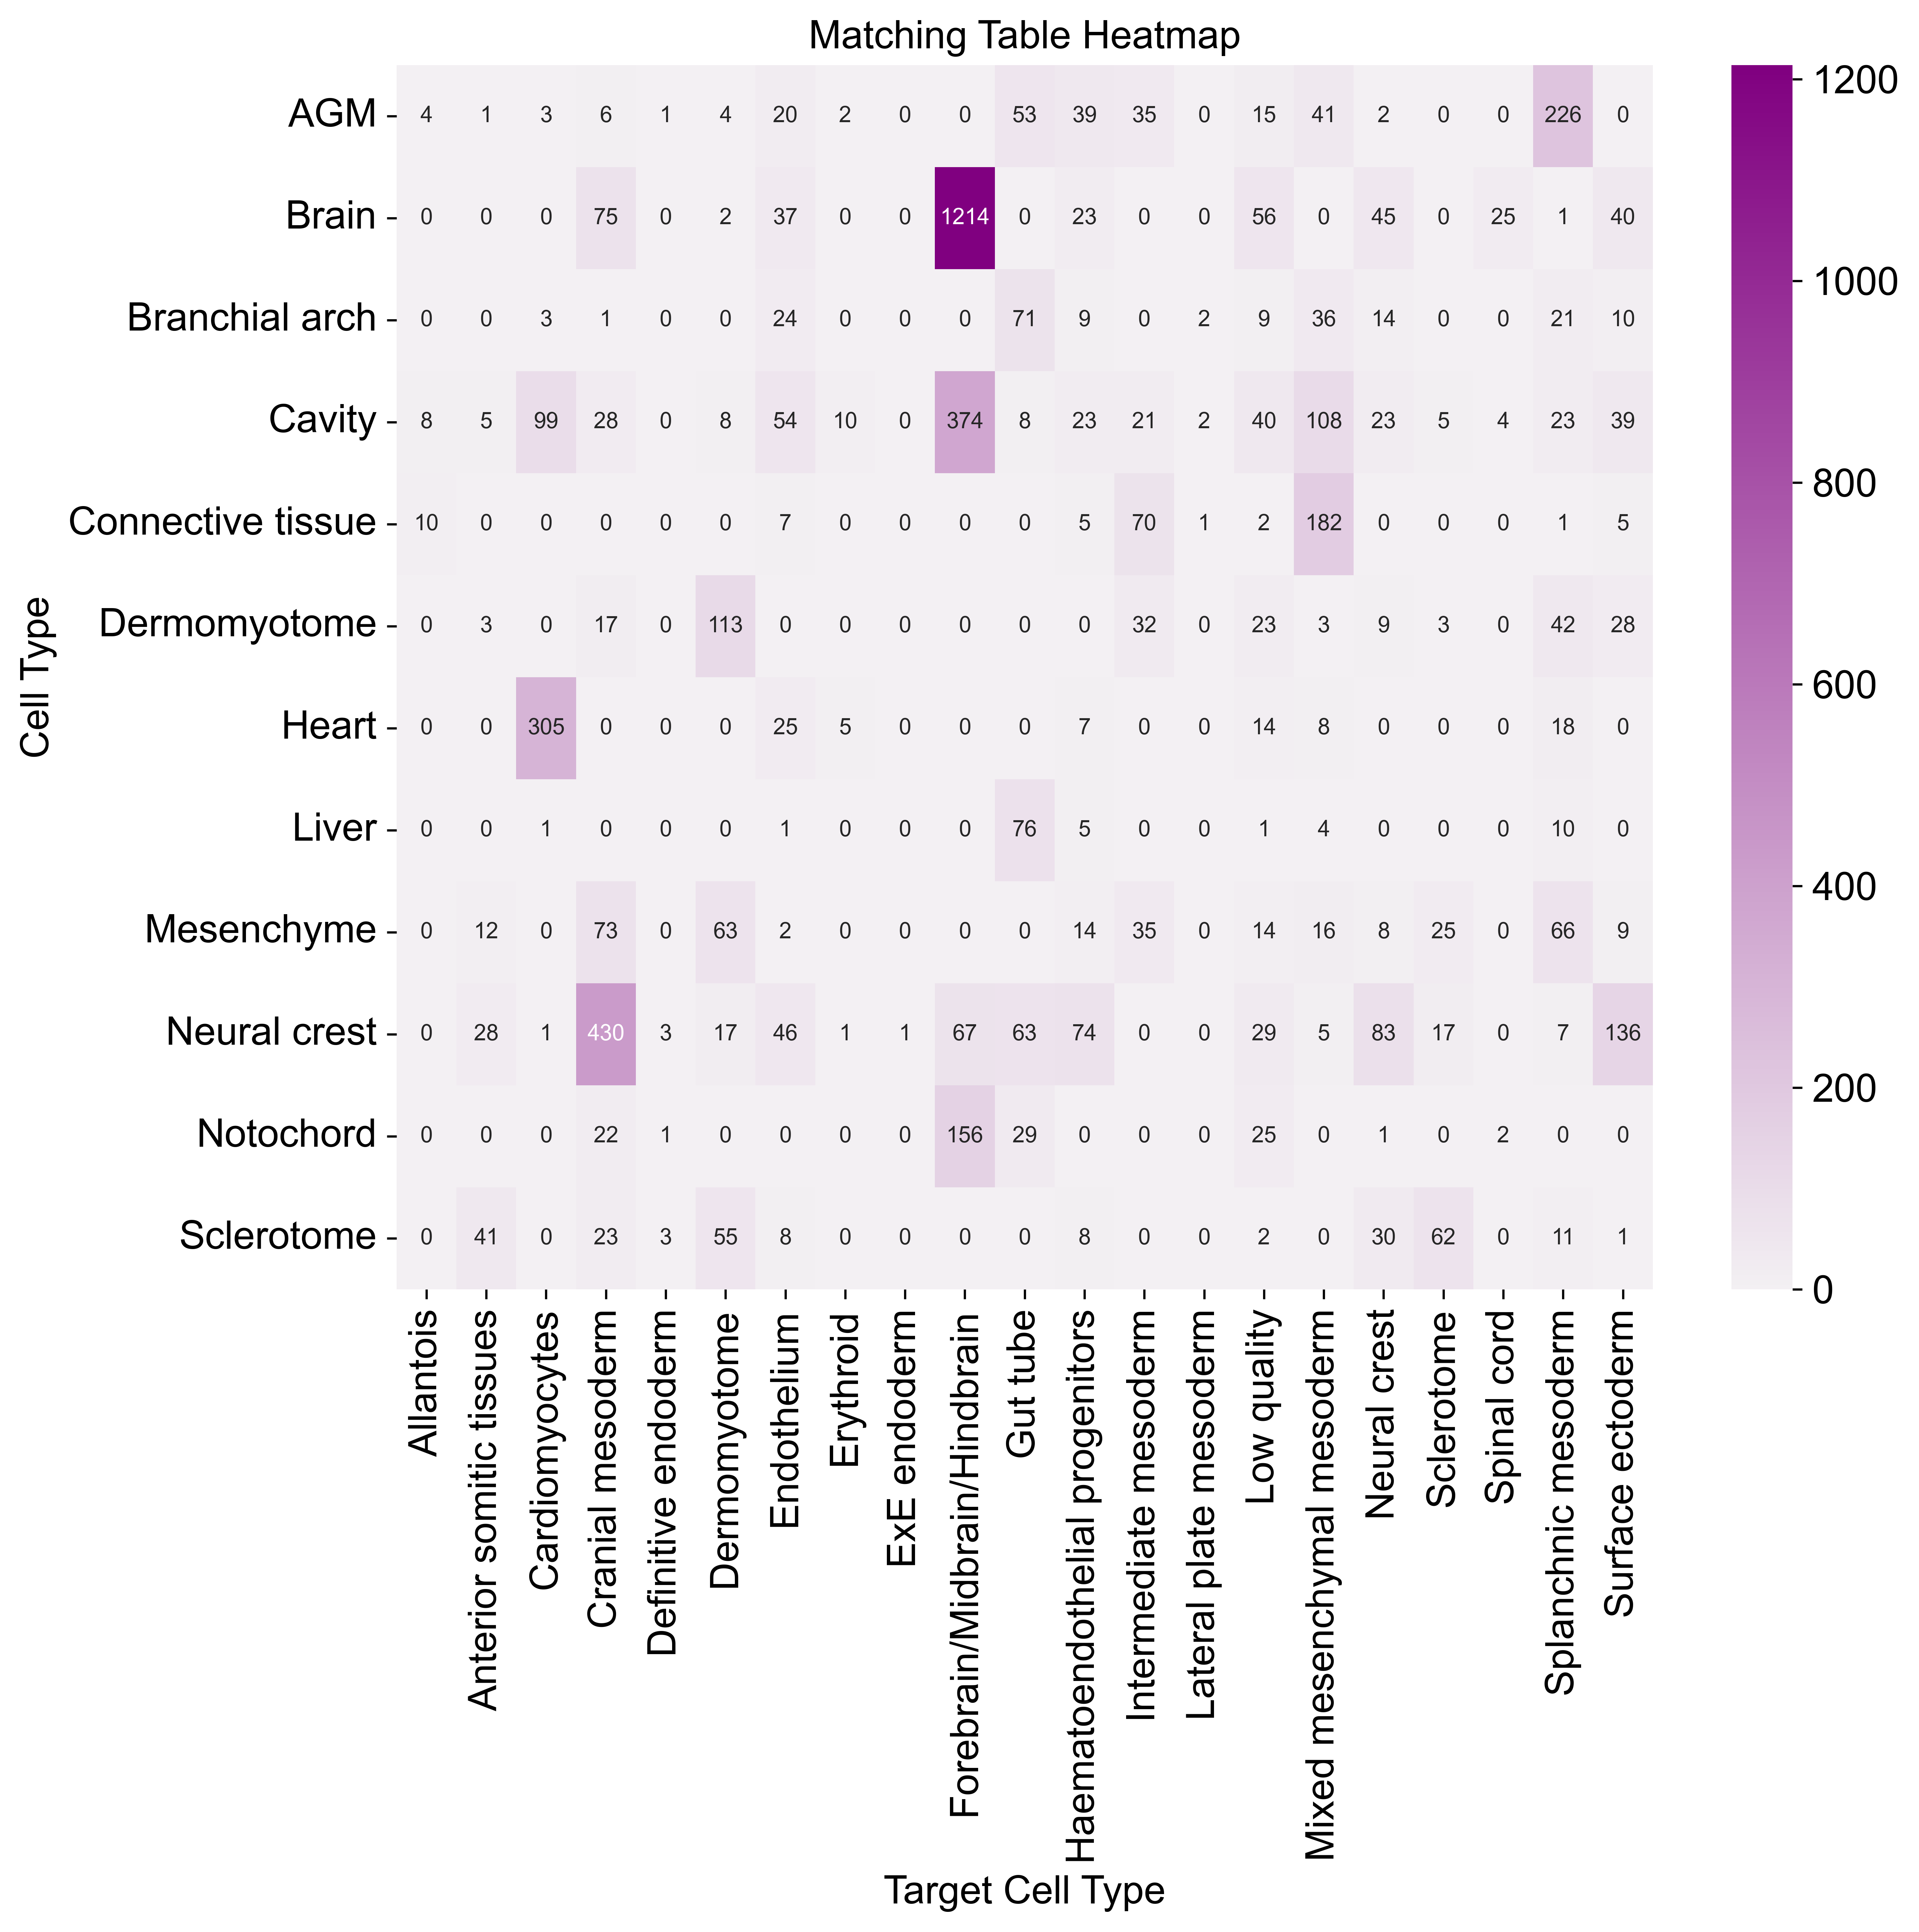

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt


sc.set_figure_params(dpi=300, dpi_save=300, transparent=True, facecolor=(1,1,1,1))
custom_cmap = sns.color_palette("light:purple", as_cmap=True)

plt.figure(figsize=(10, 8))  
sns.heatmap(matching_table, annot=True, fmt="d", cmap=custom_cmap, annot_kws={'fontsize': 8})  

plt.title('Matching Table Heatmap')
plt.xlabel('Target Cell Type')
plt.ylabel('Cell Type')
plt.show()

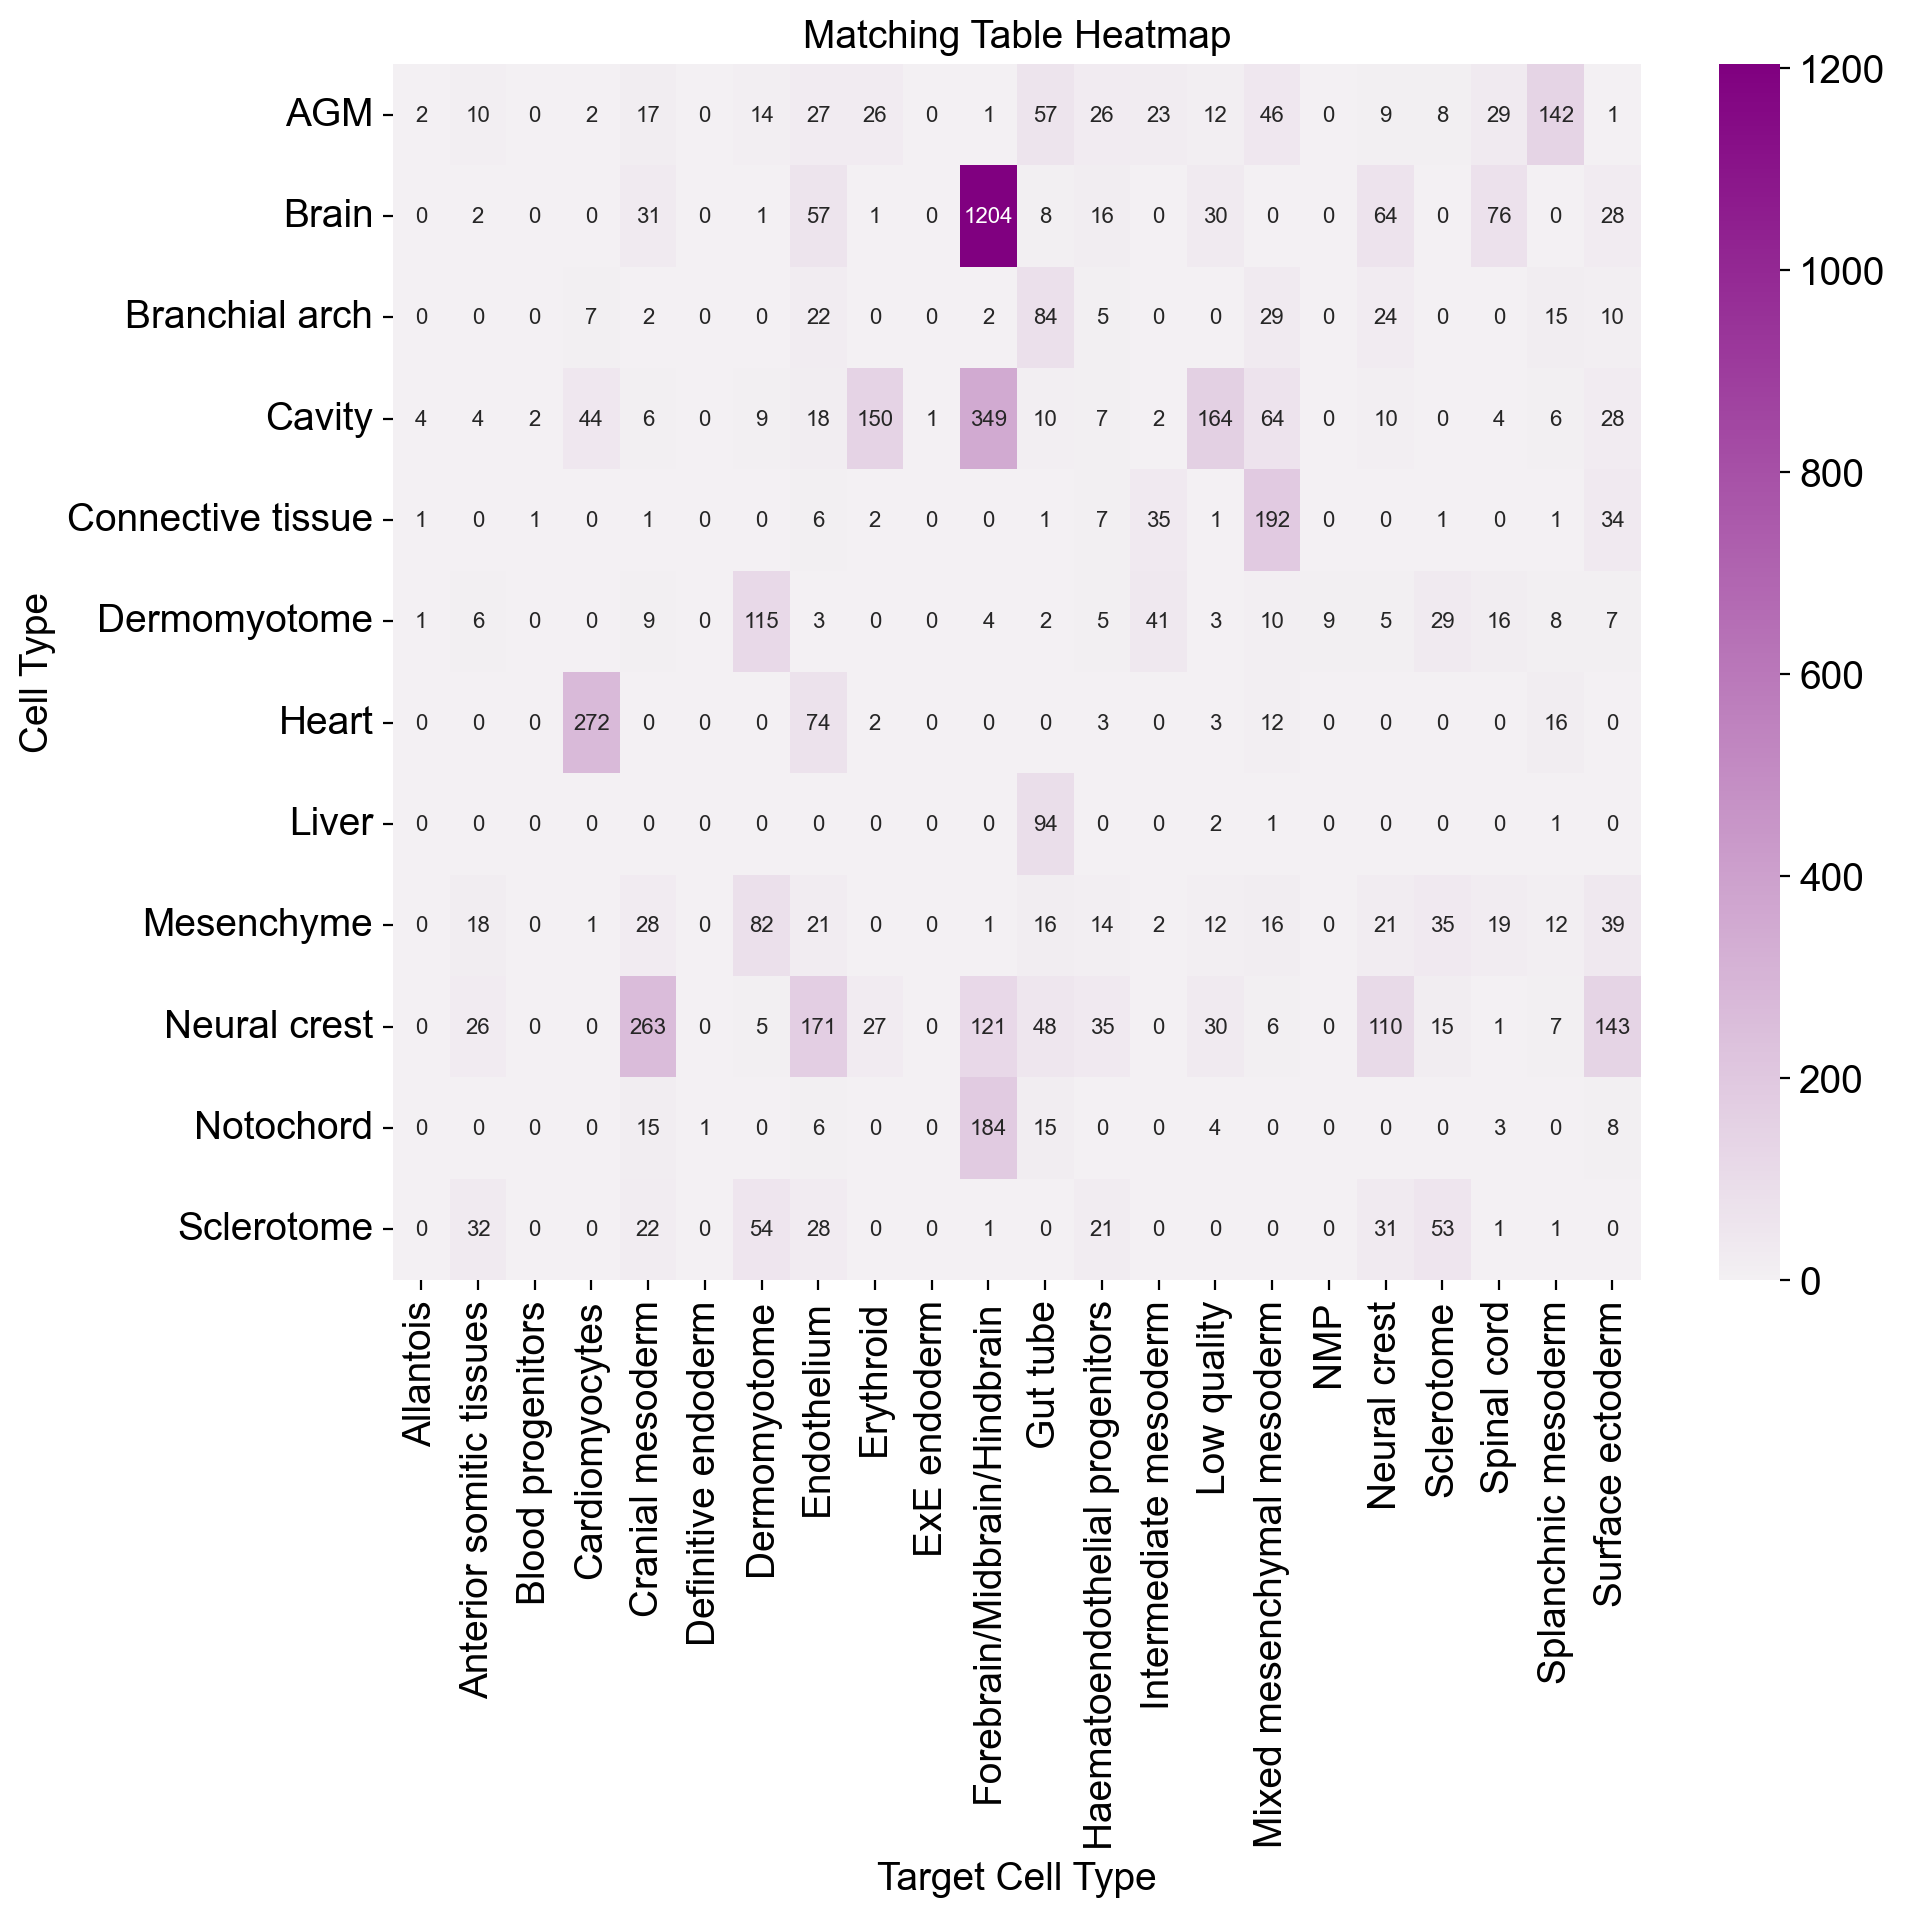

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt


sc.set_figure_params(dpi=100, dpi_save=100, transparent=True, facecolor=(1,1,1,1))
custom_cmap = sns.color_palette("light:purple", as_cmap=True)

plt.figure(figsize=(10, 8))  
sns.heatmap(matching_table_2, annot=True, fmt="d", cmap=custom_cmap, annot_kws={'fontsize': 8})  

plt.title('Matching Table Heatmap')
plt.xlabel('Target Cell Type')
plt.ylabel('Cell Type')
plt.show()